# Data Science in Python - Assignment 1

#### by Cathal Ryan, 16401146

"An assessment of excess mortality caused by the Covid-19 outbreak in Europe"

There are many ways in which people have statistically assessed the impact of the Covid-19 pandemic. Much focus is on daily case numbers and deaths, and often comparisons are made on each country's performance in handling the pandemic based on these measurements.

However, this can be flawed. Different countries have different testing capabilities, and thus case numbers could vary widely depending on a country's testing capacity and thus may not reflect the true rate of infection in a country. The death rate has similar issues, often if a country was not able to test the person for Covid-19, they cannot confirm it as a Covid-related death. There may also be differing criteria on what is counted as a death from Covid, is it simply whether the person was infected with the disease and died, or was the disease the major factor in the cause of death.

In this assignment, I intend to explore a different metric for assessing the impact of the pandemic, the total number of deaths suffered by several countries across the EU. Assuming each country reports those who have deceased accurately and in a timely fashion, this can help give us a broader picture of how the pandemic has affected mortality across Europe. We intend to observe by how much has death increased in Europe in this time, and how much this increase in death relates to the Covid-19 deaths reported by each country.

In [2]:
# Imports
import requests
import urllib.request, json 
import json
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns

## <font color=red> 1:</font> Identifying one or more suitable web APIs

Two APIs were chosen for this assignment and are integrated as required. 

- The EuroStat API, found here: https://ec.europa.eu/eurostat/online-help/public/en/API_06_DataQuery_en/
- Covid 19 API, found here: https://covid19api.com/

The Eurostat API gives access to a wide range of statistics reported across Europe. For many countries in the EU, weekly numbers of deaths are reported and added. My intention here is to collect data for a set of countries, collecting their weekly death toll from 2016 to 2020. This API is free and does not require a key.

With data of the weekly death toll in the four years previous to the pandemic, we can extract a new feature, "excess death", from the data for our analysis here. This involves gathering estimates of the average number of deaths for each week in 2016-2019. This average can then be compared to the death toll of each week in 2020. This allows us to calculate an "excess death" figure, which is how many more people have died in comparison to what would be expected from previous years. We can find this in absolute terms and in relative terms, which respectively means the absolute increase of death from previous years and the percentage increase.

The Covid-19 API allows for access to a broad range of Covid-19 related statistics. It is a free API and does not require a key, apart from some premium features which are not used for this assignment. The Covid-19 API can provide the number of people who the country announced have died from Covid-19.

The intention is to then integrate these two datasets into a single pandas dataframe for analysis, with data of Covid-19 deaths, excess deaths and the relative increase in excess death for each country. We can then plot and analyse the statistics using many of Python's plotting tools such as Matplotlib and Seaborn.

## <font color=red> 2:</font> Data retrieval, parsing, and storage

#### Eurostat API
The EuroStat API makes use of the 'Jsonstat' format, of which more information can be found here: https://json-stat.org/.
This Json structure does not allow for easy transfer to a pandas dataframe, and so we must make use of some specialised functions to parse the data found from the json dictonary we can get from a response from this API. This is parsed to an uncleaned pandas DataFrame which can be manipulated as needed in subsequent analysis. These functions are described below.

*request_df*: Takes in a url to send a request, with a starting year to start the data collection from. Executes for each country in country_codes. Calls generate_eurostat_df to create a dataframe containing better formatted data from each country, and concatenates these dataframes together for each country dataframe.

*generate_eurostat_df*: Takes in the dictionary formed from an API request, and returns a pandas dataframe in a more workable structure, with death values seperated based on the categories given in the json request. Uses *get_dimensions, get_values and get_row* to form this pandas dataframe.

*get_dimensions*: Takes in the dictionary formed from json response. For each in category of "id", the name of the dimension is found. These dimensions are named "sex", "unit", "geo", "time". Then all the possible values for these dimension are found using *get_label_dimension*, like all countries in 'geo', all weeks in 'time' etc.

*get_deaths*: Gets the values (in our case deaths) for all dimensional value combinations.

*get_row*: Returns a row of the dataframe which we intend to return, with all values except for the final death values. Calls itself recursively to return each row as needed.

In [99]:
from collections import OrderedDict
import requests

# Eurostat Data makes use of "Jsonstat" format, which we'll need to use some specific functions to get anything useful out of.

# Perform API request for each country
def request_df(url, year_start, country_codes):
    df1 = pd.DataFrame()
    for co in country_codes:
        url = url+year_start+'W01&precision=1&sex='+'T'+'&geo='+co+'&unit=NR&unitLabel=label'
        requested_object = requests.get(url)
        response = requested_object.json()
        df = generate_eurostat_df(response)
        df1 = pd.concat([df1, df]).reset_index(drop=True)
    return df1
    
# Generates a dataframe out of a json-stat format dictionary
def generate_eurostat_df(jsondict):
    death_numbers = []
    # Get the death number values from dictionary
    death_numbers = get_deaths(jsondict)
    
    # Get the dimensions from the dictionary
    dimensions, namedimensions = get_dimensions(jsondict)

    # Form as a pandas dataframe  
    # All of the values are added in like country, sex, and week through get_df_row function
    # Along with the "values", which are the deaths added from the get_values function above
    df_for_output = pd.DataFrame([categories + [death_numbers[i]] for i, categories in enumerate(get_row(dimensions))])

    # Adds in the column names
    df_for_output.columns = namedimensions + ["Deaths"]
    
    # Indexed from 0 to the number of values
    df_for_output.index = range(0, len(death_numbers))
    return df_for_output

# Returns names of all dimensions, and all the possible names under that label, like countries in geo etc, weeks in time etc.
def get_dimensions(jsondict):
    labels = [] # List of pandas dataframes with dimension category data
    names = [] # Dimension names
    dict1 = jsondict
    
    #For all categories, ie sex, unit, age etc.
    for dimension in dict1['id']:
        name = jsondict['dimension'][dimension]['label'] #Get name of the dimension
        lab = get_label_dimension(jsondict, dimension) # Get all data under that label
        
        # Append to the lists the dimension names and the data relevant to that name
        labels.append(lab)
        names.append(name) 
    return labels, names

# Gets all of the data under a dimension label.
# ie if it were week, return all the week values, but if it were country, return all the unique countries
def get_label_dimension(jsondict, dim):
    
    dim_input = jsondict['dimension'][dim] # All values under that dimension
    dim_label = dim_input['category']['label']
    
    # Form a dataframe with all the dimension labels, like all weeks, all genders etc.
    dim_label = pd.DataFrame(list(zip(dim_label.keys(), dim_label.values())),index=dim_label.keys(),columns=['id', 'label'])
    return dim_label

# returns the value of deaths for each dimension label
def get_deaths(jsondict):
    euro_death_values = jsondict['value']
    # Find all values and the key corresponding to it
    euro_death_values = {int(key): value for (key, value) in euro_death_values.items()}
    # Get the size of all values in the dictionary
    if jsondict.get('size'):
        max_val = np.prod(np.array((jsondict['size'])))
    # Assign an array of max_val size to None
    vals = max_val * [None]
    # For all the k-v pairs which exist, assign them, leaving those which don't exist as None
    for (k, v) in euro_death_values.items():
        vals[k] = v
    return vals

# list with pandas dataframe column values except for death column
def get_row(dimensions, i=0, record=None):
    # Create new record list if first time being called
    # Records are each row's individual values, except for the deaths column, could be Total, Number, Spain etc.
    if i == 0 or record is None:
        record = []
    # Iterate for however many labels there are in this dimension
    for dimension in dimensions[i]['label']:    
        record.append(dimension)
        # If number of records is equal to the dimensions, we've filled the row, yield record
        if len(record) == len(dimensions):
            yield record
        # If i+1 less than number of dimensions, recursively call again
        if i + 1 < len(dimensions):
            for row in get_row(dimensions,  i + 1, record):
                yield row
        if i + 1 == len(record) :
            record.pop()

We will gather data on the following European countries: Germany, Poland, United Kingdom, Sweden, France, Italy, Czechia and Spain. We can add as many countries as needed but I have chosen 8 as this is a fair amount to have meaningful comparisons with.
(note: Unfortunately mortality data is not provided to Eurostat for my home country of Ireland.)

The pandas dataframe formed from our *request_df* function is then passed to a json file, which we will reopen later for further analysis.

In [107]:
country_codes = ["DE", "PL", "UK", "SE", "FR", "IT", "CZ", "ES"]
main_url = 'http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/demo_r_mwk_ts?sinceTimePeriod='
year_start = "2016"
df1 = request_df(main_url, year_start, country_codes)
df1.to_json("Assignment1_EuroStat.json") # Pass to json

#### Covid-19 API

Thankfully, the Covid-19 API provides Json response in an easily manipulated format. The simple function *generate_covid_api_df* takes in a list of countries, and generates the response from the API which is given in json format. This is called for a collection of countries, and we concatenate into a single dataframe.

From this dataframe, we parse back to json format, for us to store our collected data for subsequent analysis.

In [108]:

# Function to get dataframe formed from calling Covid-19 API for a collection of countries 
def generate_covid_api_df (covid_countries):
    cov_df = pd.DataFrame()
    for country in covid_countries:
        #Start from 3rd of February (week 6 begin date of 2020)
        with requests.get('https://api.covid19api.com/total/country/'+country+"?from=2020-02-03T00:00:00Z&to=2021-02-21T00:00:00Z") as url:
            data = url.json()
            df = pd.DataFrame(json_normalize(data))
        cov_df = pd.concat([cov_df, df]).reset_index(drop=True)
    return cov_df

covid_countries = ["germany", "poland", "uk", "sweden", "france", "italy", "czechia", "spain"]

covid_df = generate_covid_api_df(covid_countries)
covid_df.reset_index(drop=True)
covid_df.to_json("Assignment1_Covid.json") # Save to json

## <font color=red> 3:</font> Data Preparation and Cleaning

We have successfully gathered data regarding European total deaths and Covid-19 deaths, and saved it to json format. We can now load up our data and prepare and clean it for integration and then analysis. We will begin with the raw data that was received from the Eurostat API.

#### Eurostat API data

In [3]:
euro_df = pd.read_json("Assignment1_EuroStat.json")
covid_df = pd.read_json("Assignment1_Covid.json")

euro_df

,sex,unit,geo,time,Deaths
0,Total,Number,Germany (until 1990 former territory of the FRG),2016W01,18467.0
1,Total,Number,Germany (until 1990 former territory of the FRG),2015W53,NaN
2,Total,Number,Germany (until 1990 former territory of the FRG),2016W02,18439.0
3,Total,Number,Germany (until 1990 former territory of the FRG),2016W03,18627.0
4,Total,Number,Germany (until 1990 former territory of the FRG),2016W04,18707.0
...,...,...,...,...,...
10039,Total,Number,United Kingdom,2021W08,NaN
10040,Total,Number,United Kingdom,2021W09,NaN
10041,Total,Number,United Kingdom,2021W10,NaN
10042,Total,Number,United Kingdom,Unknown week,NaN


We can see that the *euro_df* is given as a large dataframe in which each row provides a unique datapoint for a country's total death count for a particular week, potentially seperated by gender or given as the total amount (males and females combined).  

Cleaning is required as Germany's name is too verbose, listed with an additonal "until 1990..". This is modified to just "Germany" for simplicity and integration with the Covid-19 API data later.

Also the "unit" column has no meaning here. We have collected data simply for all genders, and so "sex" is not a useful feature to us either. These features are thus removed from the data.

Also, many countries report data in error for weeks such as "W99". When a week is not known, they are reported as "Unknown week". These all must be cut from the dataset as they are reported in error.

We can also better structure this data by indexing based on the week, with unique columns for each country. As is stands, each week has a unique row for each country which may not be a good structure for this time-series data, as we cannot easily compare points in time by country.

Also, many countries only report their weekly deaths up to the end of 2020, rather than into the early weeks of 2021. In order to have our data be more homogenous, we will filter out any weeks which include NaN values. This means removing rows in our case.

Let us then clean this dataset accordingly.


In [4]:
euro_df = euro_df.drop(['unit', 'sex'],axis=1) # "unit" and "sex" column is meaningless for us.
euro_df['geo'] = euro_df['geo'].replace([euro_df['geo'][0]],'Germany') # "Germany" is reported as until 1990 former territory of FRG, need to simpify.

euro_df = euro_df.dropna(axis=0) # Remove any NaN values
# Remove any other weird weeks if drop NA doesn't catch them
euro_df = euro_df[euro_df['time'].str.contains("W53") == False]
euro_df = euro_df[euro_df['time'].str.contains("W99") == False]
euro_df = euro_df[euro_df['time'].str.contains("Unknown") == False]

In [5]:
euro_df = euro_df.pivot_table("Deaths", ["time"], "geo")
# Remove NaN values again, so we only have indexed rows with valid values.
euro_df = euro_df.dropna()
euro_df

geo,Czechia,France,Germany,Italy,Poland,Spain,Sweden,United Kingdom
time,,,,,,,,
2016W01,2222.0,12183.0,18467.0,13517.0,8215.0,8658.0,1860.0,14841.0
2016W02,2054.0,12247.0,18439.0,13055.0,7920.0,8671.0,1914.0,13126.0
2016W03,2175.0,12403.0,18627.0,13545.0,7683.0,8791.0,1958.0,13039.0
2016W04,2116.0,12065.0,18707.0,13388.0,7977.0,8491.0,2006.0,12869.0
2016W05,2137.0,11963.0,18493.0,12997.0,7970.0,8461.0,1909.0,12546.0
...,...,...,...,...,...,...,...,...
2020W47,3422.0,15261.0,20162.0,18784.0,14827.0,9948.0,1989.0,14276.0
2020W48,3168.0,14962.0,21258.0,18887.0,13626.0,9764.0,1959.0,14106.0
2020W49,3102.0,14800.0,22606.0,17995.0,12978.0,9775.0,2148.0,13956.0


We can see here a more structured, cleaned dataset whereby each week of each year is indexed, while each column corresponds to the total number of deaths seen by the country in that week. Let us then look at some of the description of each country.

In [6]:
euro_df.describe()

geo,Czechia,France,Germany,Italy,Poland,Spain,Sweden,United Kingdom
count,259.000000,259.00000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,2191.698842,11828.76834,18050.335907,12692.308880,7992.675676,8293.965251,1720.312741,11903.235521
std,340.606336,1461.83300,1889.816208,2074.098672,1344.483199,1636.822083,197.405278,2068.258102
min,1770.000000,9926.00000,15439.000000,10321.000000,6596.000000,6641.000000,1441.000000,8360.000000
25%,2010.500000,10770.50000,16638.000000,11320.500000,7331.000000,7336.000000,1565.000000,10587.000000
50%,2103.000000,11436.00000,17604.000000,12024.000000,7689.000000,7875.000000,1690.000000,11424.000000
75%,2237.000000,12387.50000,18965.500000,13298.000000,8172.500000,8651.500000,1825.000000,12615.000000
max,4235.000000,19049.00000,26777.000000,23457.000000,16242.000000,20809.000000,2569.000000,24659.000000


In [7]:
euro_df.dtypes.value_counts() 

float64    8
dtype: int64

In [8]:
euro_df.isnull().sum()

geo
Czechia           0
France            0
Germany           0
Italy             0
Poland            0
Spain             0
Sweden            0
United Kingdom    0
dtype: int64

We have 259 instances for each country's weekly death figures, with 52 weeks in each year apart from 2020 where we have 51. Addditionally, we have exclusively float 64 values present, with no null values. This is all highly indicative that all values are present.

We can briefly see the distribution of the data in the description above. Germany typically sees the most weekly mortality, presumably as it is the largest country in terms of population. The other countries follow similar population based trends, whereby smaller countries such as Belgium, Czechia and Sweden report lower mean death values than the larger countries.

Interestingly, the maximum death is quite a bit higher in many countries relative to the mean average weekly death. We would suspect this is due to Covid-19.

We have succesfully cleaned the weekly death data from 2016 to 2020 for these European countries. This will allow us to easily find the excess death figures for each country in 2020. Now, we will clean the data from the Covid-19 API, which is saved in *covid_df*.

#### Covid-19 API data

In [9]:
covid_df

,Country,CountryCode,Province,City,CityCode,Lat,Lon,Confirmed,Deaths,Recovered,Active,Date
0,Germany,,,,,0,0,12,0,0,12,2020-02-03 00:00:00+00:00
1,Germany,,,,,0,0,12,0,0,12,2020-02-04 00:00:00+00:00
2,Germany,,,,,0,0,12,0,0,12,2020-02-05 00:00:00+00:00
3,Germany,,,,,0,0,12,0,0,12,2020-02-06 00:00:00+00:00
4,Germany,,,,,0,0,13,0,0,13,2020-02-07 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
3075,Spain,,,,,0,0,3107172,66316,150376,2890480,2021-02-17 00:00:00+00:00
3076,Spain,,,,,0,0,3121687,66704,150376,2904607,2021-02-18 00:00:00+00:00
3077,Spain,,,,,0,0,3133122,67101,150376,2915645,2021-02-19 00:00:00+00:00
3078,Spain,,,,,0,0,3133122,67101,150376,2915645,2021-02-20 00:00:00+00:00


The data produced here is quite different in scope to that seen from the Eurostat API's weekly death figures. Namely, the confirmed deaths from Covid are a cumulative figure, which constrasts to that seen in the Eurostat API's figures specific to the week. Also, the figures are given daily in a different date format to the Eurostat API. This will require preprocessing to allow adequate integration of the two datasets.

Also, there are features here which will not be relevant to our analysis, such as extra geographical features and case numbers. These will be removed for further analysis.

Additionally, Czech Republic is labelled as "Czechia" in the Eurostat API. We will rename this column as Czechia in the Covid-19 API data for easy integration.

In [10]:
covid_df= covid_df.drop(['Recovered', 'Active', 'CountryCode'],axis=1) # Useless columns for us
covid_df= covid_df.drop(['Lat', 'Lon', 'City', 'CityCode', 'Province'],axis=1)
covid_df['Country'] = covid_df['Country'].replace('Czech Republic','Czechia')
covid_df = covid_df.dropna(axis=0)
covid_df.isnull().sum()

Country      0
Confirmed    0
Deaths       0
Date         0
dtype: int64

To make it easy to integrate the data, we'll change the columns to be based on the particular country, using the pivot_table function. This allows us to compare countries more easily also.

In [11]:
#euro_df.set_index("time").pivot(columns="geo", values="Deaths")
covid_df = covid_df.pivot_table("Deaths", ["Date"], "Country")
#euro_df.reset_index.pivot_table()
covid_df

Country,Czechia,France,Germany,Italy,Poland,Spain,Sweden,United Kingdom
Date,,,,,,,,
2020-02-03 00:00:00+00:00,0,0,0,0,0,0,0,0
2020-02-04 00:00:00+00:00,0,0,0,0,0,0,0,0
2020-02-05 00:00:00+00:00,0,0,0,0,0,0,0,0
2020-02-06 00:00:00+00:00,0,0,0,0,0,0,0,0
2020-02-07 00:00:00+00:00,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2021-02-17 00:00:00+00:00,18596,83271,66732,94540,41308,66316,12569,119159
2021-02-18 00:00:00+00:00,18739,83542,67245,94887,41582,66704,12598,119614
2021-02-19 00:00:00+00:00,18913,84114,67741,95235,41823,67101,12649,120147


## <font color=red> 4:</font> Data Integration and Feature Engineering

We have gathered a dataset with the number of European death figures from 2016 to 2020, saved in *euro_df*. We have assessed and cleaned this data, allowing further analysis to be completed.

This dataset allows us to calculate the features which form our main analysis. We apply feature engineering here, whereby we are creating new features of the dataset from the existing features. By calculating the average death toll for a week of each year prior to the pandemic (2016 to 2019), an estimated expected death toll can be found. The difference between this average and the equivalent week in 2020 can be considered as the estimated excess death toll. This is to be found in relative and in absolute terms, and will form columns of data for our final dataframe.

The function *df_excess_mortality* takes in the dataframe euro_df, which describes the death toll for the set of European countries by week, computes an average for each week prior to 2020, and gives the excess found in 2020. A new dataframe is returned with hierarchical indexing based on country, followed by Total Deaths, Excess Deaths and Relative Increase of Deaths.

In *covid_df* we have gathered a dataset which constitutes each Covid-19 death for each day in the pandemic. To integrate this with the new dataframe with computed excess deaths, we write the function *integrate_covid_deaths*. This function converts this cumulative daily figure found in *covid_df* into a weekly total specific to the week in question, and adds it to our larger dataframe to directly compare the weekly covid deaths to excess deaths seen during the pandemic. 

These functions are written below.

In [12]:
# Calculates the excess mortality for each week in 2020 from Eurostat API data for mortality in 2016-2020
# returning new dataframe with Total Death, Excess Death and Relative Increase in Death for each country 
def df_excess_mortality(countries, euro_df):
    df_1 = pd.DataFrame()
    for country in countries:
        sex = "Total"
        # Reserve dataframe to just the country in question
        df = pd.DataFrame(euro_df[country])
        # Find where the start of pandemic was (we deem it as week 6 of 2020) and its index
        # Create a copy of the original dataframe, from just when pandemic began, rename Column as total death
        df1 = (df["2020W06"::].rename(columns={country: 'Total death'}))
        sequence=[]
        #Starting 2020W06, go through each week of the pandemic
        for j in range(0,len(df1)): 
            str1 = df1.index[j] # Find what week we're on
            # Extrapolate the week from the string, ie 2020W06 becomes W06
            str1 = df1.index[j][-3:]
            
            # Any containing this week, average them and add this to the list of averages for previous 4 years.
            df_copy = df[:"2020W05"].iloc[df[:"2020W05"].index.str.contains(str1,regex=False)]
            
            # The mean of this is the average death rate for that particular week for that country
            sequence.append(df_copy.mean())
        
        # Update dataframe with calculated Excess death and relative increase in death
        df1vals = df1.values
        df1['Excess death'] = df1vals - sequence
        df1['Relative death'] = df1vals / sequence
        df1.columns = pd.MultiIndex.from_product([[country],['Total death','Excess death','Relative death']])
        df_1 = pd.concat([df_1, df1],axis=1)
    return df_1

In [13]:
# Integrates Covid API data, in covid_df, to excess_df. Converts to absolute figure for particular  
# week rather than cumulative daily figure.
def integrate_covid_deaths(countries, excess_df, covid_df):
    # For each country we want data for
    for countr in countries:
        covids=[]
        # For each week in the Excess deaths dataframe
        for week in list(excess_df.index):
            week_part = week[-2:] # Just get the week part of index e.g. "W06"
            year = week[0:4] # Get the year part
            count = int(week_part) - 5 # Index to begin
            # If we extend data to 2021, this can be included
            if (int(year)==2021):
                count=count+52
            countrydf = covid_df[countr].reset_index(drop=True) # Drop index to just numbers, not days
            # Find the difference in death in 7 days and add it to list
            dead = countrydf.loc[count*7] - countrydf.loc[(count-1)*7] 
            covids.append(float(dead)) 
        #Covid deaths for this country have been found, add to dataframe
        excess_df[countr, 'Covid death'] = covids
    excess_df = excess_df.sort_index(axis=1)
    return excess_df

We can now call our functions and look at our new dataframe, which will be prepared and ready for our analysis.

In [14]:
countries = ["Germany", "Poland", "United Kingdom", "Sweden", "France", "Italy", "Czechia", "Spain"]
excess_df = df_excess_mortality(countries, euro_df)
excess_df = integrate_covid_deaths(countries, excess_df, covid_df)

## <font color=red> 5:</font> Data Analysis

### Description of the dataset

Through our data cleaning and preparation, we have successfully landed at the following data set, stored in the pandas dataframe *excess_df*. Each row represents a week in the pandemic. The columns are indexed hierarchically, with the country followed by one of four categories - Covid Death, Excess Death, Relative Death, and Total Death.

1. Covid Death - The total number of Covid-19 fatalities confirmed for a given week.

2. Excess Death - The calculated absolute increase of death found in a given week, calculated as the difference between the total death found in this week, and the average of the previous four years. For instance, if a given week had on average 1000 people die in the previous 4 years, the excess death would be 500 if 1500 people died in 2020.

3. Relative Death - The total death for each week, divided by the average seen in previous years. Allows for easier comparison between countries, as this is a relative figure rather than absolute. For instance, a relative death value of 1.1 would indicate a 10% increase on the average of the previous four years.

4. Total death - The total number of deaths seen for a week in the pandemic in 2020.

The row index on the right hand side is denoted as "time". This represents a week in 2020, e.g. 2020W06 is the 6th week of 2020.


In [15]:
excess_df.round(decimals=2)

Czechia                                              France  \
        Covid death Excess death Relative death Total death Covid death   
time                                                                      
2020W06         0.0       -80.50           0.97      2353.0         0.0   
2020W07         0.0       -49.75           0.98      2391.0         1.0   
2020W08         0.0      -108.25           0.96      2347.0         0.0   
2020W09         0.0       -70.00           0.97      2360.0         2.0   
2020W10         0.0      -132.50           0.95      2292.0        22.0   
2020W11         0.0       -38.75           0.98      2302.0       124.0   
2020W12         1.0        60.00           1.03      2324.0       713.0   
2020W13        22.0       100.75           1.05      2294.0      2164.0   
2020W14        55.0       172.00           1.08      2322.0      5888.0   
2020W15        65.0       121.25           1.06      2239.0      6055.0   
2020W16        51.0        91.25           1.04      2128.0      5272.0   
2020W17        29.0       -58.50           0.97      2031.0      3026.0   
2020W18        29.0        88.00           1.04      2112.0      1937.0   
2020W19        30.0       -33.50           0.98      1998.0      1442.0   
2020W20        15.0        46.75           1.02      2028.0      1596.0   
2020W21        20.0       -66.00           0.97      1919.0       219.0   
2020W22         4.0      -104.75           0.95      1936.0       376.0   
2020W23         7.0       189.25           1.10      2136.0       376.0   
2020W24         2.0         7.75           1.00      1983.0       226.0   
2020W25         6.0        31.25           1.02      2026.0       229.0   
2020W26        12.0       101.00           1.05      2080.0       148.0   
2020W27         2.0       146.00           1.07      2112.0       109.0   
2020W28         3.0        45.75           1.02      1996.0       110.0   
2020W29         6.0       -15.50           0.99      1991.0       147.0   
2020W30        14.0        77.00           1.04      2086.0        32.0   
2020W31        13.0       157.75           1.08      2231.0        84.0   
2020W32         4.0       178.25           1.09      2164.0        46.0   
2020W33         9.0       248.25           1.13      2188.0        90.0   
2020W34        16.0       103.75           1.05      2103.0       100.0   
2020W35         9.0        79.25           1.04      2034.0       112.0   
2020W36        13.0        90.75           1.05      2041.0        89.0   
2020W37        28.0       116.25           1.06      2086.0       228.0   
2020W38        57.0       228.50           1.11      2223.0       388.0   
2020W39        96.0       345.00           1.17      2389.0       474.0   
2020W40       140.0       257.50           1.12      2383.0       474.0   
2020W41       293.0       481.00           1.23      2609.0       528.0   
2020W42       462.0       880.00           1.42      2951.0       804.0   
2020W43       852.0      1570.25           1.76      3645.0      1407.0   
2020W44      1289.0      2152.00           2.04      4218.0      2448.0   
2020W45      1374.0      2194.00           2.07      4235.0      3564.0   
2020W46      1388.0      1755.75           1.83      3859.0      4074.0   
2020W47       944.0      1304.75           1.62      3422.0      4187.0   
2020W48       935.0      1050.50           1.50      3168.0      3508.0   
2020W49       607.0       958.50           1.45      3102.0      2794.0   
2020W50       707.0       914.75           1.42      3103.0      2778.0   
2020W51       802.0       967.75           1.43      3244.0      2628.0   

                                                    Germany               ...  \
        Excess death Relative death Total death Covid death Excess death  ...   
time                                                                      ...   
2020W06      -584.00           0.96     12659.0         0.0     -1298.00  ...   
2020W07     

It would be wise here to check that our data cleaning and processing has remained succesful.

In [16]:
excess_df.isnull().sum()

Czechia         Covid death       0
                Excess death      0
                Relative death    0
                Total death       0
France          Covid death       0
                Excess death      0
                Relative death    0
                Total death       0
Germany         Covid death       0
                Excess death      0
                Relative death    0
                Total death       0
Italy           Covid death       0
                Excess death      0
                Relative death    0
                Total death       0
Poland          Covid death       0
                Excess death      0
                Relative death    0
                Total death       0
Spain           Covid death       0
                Excess death      0
                Relative death    0
                Total death       0
Sweden          Covid death       0
                Excess death      0
                Relative death    0
                Total death 

In [17]:
excess_df.round(decimals=2).dtypes.value_counts() 

float64    32
dtype: int64

We see no null values, and each column has values of type float, with 32 columns in total, 8 countries with 4 categories in each. We can thus be satisfied with our dataset containing all values as needed, and thus can show the following descriptive statistics for the data.

In [18]:
excess_df.iloc[:, : 16].describe()

Czechia                                                France  \
       Covid death Excess death Relative death  Total death  Covid death   
count    46.000000    46.000000      46.000000    46.000000    46.000000   
mean    226.326087   359.880435       1.172810  2460.521739  1326.500000   
std     407.414016   599.095765       0.286556   607.155471  1716.539358   
min       0.000000  -132.500000       0.945350  1919.000000     0.000000   
25%       4.500000    13.625000       1.006859  2081.500000   109.250000   
50%      18.000000   102.375000       1.051465  2235.000000   382.000000   
75%     129.000000   323.125000       1.158585  2390.500000  2377.000000   
max    1388.000000  2194.000000       2.074963  4235.000000  6055.000000   

                                                     Germany               \
      Excess death Relative death   Total death  Covid death Excess death   
count    46.000000      46.000000     46.000000    46.000000    46.000000   
mean   1365.500000       1.118953  12717.826087   589.347826   874.603261   
std    1878.763474       0.160896   2144.507706   965.457571  1610.944843   
min    -734.000000       0.943591  10279.000000     0.000000 -2040.250000   
25%     145.187500       1.013865  11005.750000    31.500000    68.375000   
50%     597.500000       1.056768  12123.500000    99.000000   740.250000   
75%    2345.187500       1.190967  14311.750000   721.250000  1376.437500   
max    7375.500000       1.631816  19049.000000  4476.000000  5677.000000   

                                          Italy                               \
      Relative death   Total death  Covid death  Excess death Relative death   
count      46.000000     46.000000    46.000000     46.000000      46.000000   
mean        1.051131  18565.521739  1504.652174   2295.951087       1.187910   
std         0.086018   1929.435458  1850.050609   2988.374807       0.240433   
min         0.903094  16162.000000     0.000000   -625.250000       0.944830   
25%         1.003935  17191.500000    88.000000     61.562500       1.005431   
50%         1.043051  17812.500000   411.000000    908.000000       1.079028   
75%         1.079277  19682.000000  2820.000000   4335.125000       1.349387   
max         1.299073  24659.000000  5514.000000  10881.000000       1.865219   

                     
        Total death  
count     46.000000  
mean   14248.391304  
std     3330.744711  
min    10708.000000  
25%    11776.000000  
50%    12735.000000  
75%    16994.000000  
max    23457.000000

In [19]:
excess_df.iloc[:, 16: 32].describe()

Poland                                                  Spain  \
       Covid death Excess death Relative death   Total death  Covid death   
count    46.000000    46.000000      46.000000     46.000000    46.000000   
mean    553.782609  1537.402174       1.203002   9137.804348  1070.869565   
std    1005.052987  2424.872735       0.315796   2473.169506  1411.480682   
min       0.000000  -640.500000       0.928703   7309.000000  -875.000000   
25%      58.750000   188.125000       1.025401   7668.500000    30.500000   
50%      87.500000   466.000000       1.064838   8108.500000   781.000000   
75%     204.500000  1167.437500       1.169894   8586.500000  1524.500000   
max    3376.000000  8727.000000       2.161277  16242.000000  5625.000000   

                                                      Sweden               \
       Excess death Relative death   Total death Covid death Excess death   
count     46.000000      46.000000     46.000000   46.000000    46.000000   
mean    1697.646739       1.217623   9453.543478  173.760870   137.755435   
std     2824.185456       0.347801   2937.226414  196.280546   268.243792   
min     -699.000000       0.916482   6742.000000   -1.000000  -185.500000   
25%      234.437500       1.031751   7959.500000   15.000000   -51.250000   
50%     1091.875000       1.151554   8459.000000   88.500000    24.625000   
75%     1567.062500       1.211902   9751.000000  287.000000   306.937500   
max    12730.750000       2.575929  20809.000000  694.000000   847.500000   

                                  United Kingdom                               \
      Relative death  Total death    Covid death  Excess death Relative death   
count      46.000000    46.000000      46.000000     46.000000      46.000000   
mean        1.083102  1807.347826    1472.130435   1685.179348       1.146575   
std         0.156930   293.511780    1768.895143   3271.617536       0.281010   
min         0.905478  1486.000000       0.000000  -1730.750000       0.838786   
25%         0.971387  1566.250000      89.500000   -152.312500       0.985583   
50%         1.016036  1724.500000     501.000000    592.125000       1.054491   
75%         1.183827  1981.500000    2781.000000   1820.125000       1.166448   
max         1.492303  2569.000000    6603.000000  13130.000000       2.138867   

                     
        Total death  
count     46.000000  
mean   13046.869565  
std     3501.187878  
min     9005.000000  
25%    10803.250000  
50%    12282.500000  
75%    13945.750000  
max    24659.000000

There are 46 weeks recorded for each country, and we can see the distribution of data for each category seperated by country.

### Visualisations and Analysis

#### Relative increase in death by week

The relative death is a very interesting statistic here as it can provide a direct sight at the measure of how much of an increase in death has been seen in each week, thus allowing for direct comparison between countries throughout each week of the pandemic in 2020. To see this, we can use the following time series plot for our 8 countries.

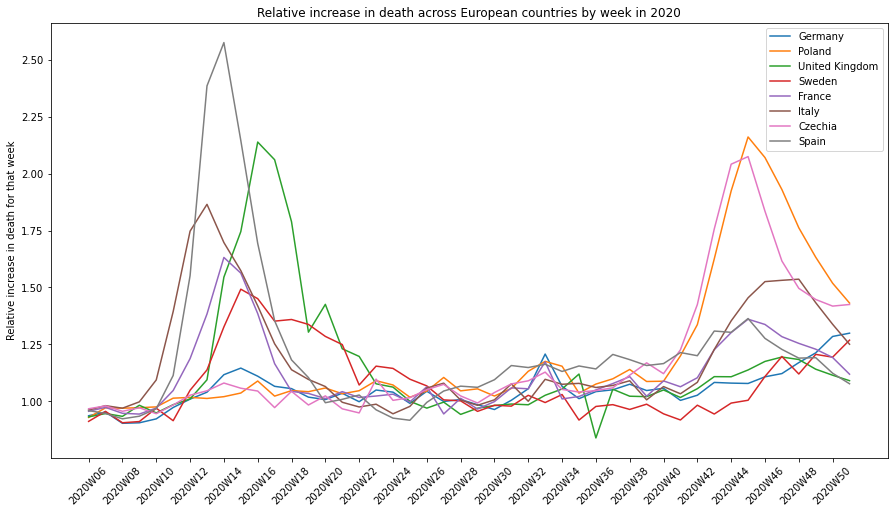

In [20]:
# Plots the relative increase in death for European countries during the pandemic. A relative ratio of 2.0 would mean that 
# deaths in a particular week are twice normal.
def plot_relative_death(df_1,countries):
    # Convert to a series
    for country in countries:
        df = df_1[country]['Relative death']
        plt.plot(df.index,df.values)
    labels = []
    j=0
    for index in df_1.index:
        if (j%2==0):
            labels.append(index)
        j=j+1
    
    plt.xticks(range(0,len(df_1),2), labels, rotation=45)
    plt.title("Relative increase in death across European countries by week in 2020")
    plt.ylabel("Relative increase in death for that week")
    plt.legend(countries)

plt.figure(figsize=(15,8))
plot_relative_death(excess_df,countries)

We can see that the excess death in Europe coincides very well with our expectations from the Covid-19 pandemic. This clearly provides empirical evidence that the number of deaths observed and the number of deaths which could have been expected in 2020 differ by a great deal. Covid-19 has clearly led to an increased pattern of excess mortality across Europe.

We can immediately see here that excess death has far exceeded levels seen in the previous four years in 2020 at various stages in the year. In many countries, this is most prominent between Week 10 and Week 20 of 2020, which is between March and May 2020. This is when most European countries were engaged in heavy lockdowns to quell the spread of the disease. 

The data provides us with an insight into when each country experienced a spike in excess mortality. We can see that Italy, shown in brown, is the country which first experiences a ramp up of excess death, as we would expect as they were the first country here to face a massive outbreak of the virus. Countries such as Czechia and Poland which largely escaped the first wave have a very prominent peak towards the latter half of the year, showcasing the effects of the 2nd wave in the latter portion of the year.

We also see the incredible extent to which the introduction of lockdown measures contributed to bringing mortality down. Countries with signficant peaks of death above the normal levels returned to near normal levels by the summer time (Week 22 onwards). Most of these countries engaged in heavy lockdowns during this period, such as the UK, Spain, France, and Italy.

Let us then look at the peak and mean values for this relative increase in death on previous years.

In [21]:
print("Peak relative excess death for select European countries in 2020\n")
print("Country".ljust(16), "Ratio".ljust(8), "Week".ljust(6))
for country in countries:
    print(country.ljust(14), "  (%.2f)  " % (excess_df[country]["Relative death"].max()), (excess_df[country]["Relative death"].idxmax()))

Peak relative excess death for select European countries in 2020

Country          Ratio    Week  
Germany          (1.30)   2020W51
Poland           (2.16)   2020W45
United Kingdom   (2.14)   2020W16
Sweden           (1.49)   2020W15
France           (1.63)   2020W14
Italy            (1.87)   2020W13
Czechia          (2.07)   2020W45
Spain            (2.58)   2020W14


In [22]:
print("Mean and median relative excess death for select European countries in 2020\n")
print("Country".ljust(16), "Median".ljust(8), "Mean".ljust(6))
for country in countries:
    print(country.ljust(14), "  (%.2f)   (%.2f) " % (excess_df[country]["Relative death"].median(), (excess_df[country]["Relative death"].mean())))

Mean and median relative excess death for select European countries in 2020

Country          Median   Mean  
Germany          (1.04)   (1.05) 
Poland           (1.06)   (1.20) 
United Kingdom   (1.05)   (1.15) 
Sweden           (1.02)   (1.08) 
France           (1.06)   (1.12) 
Italy            (1.08)   (1.19) 
Czechia          (1.05)   (1.17) 
Spain            (1.15)   (1.22) 


These figures indicate to us how in some countries such as Germany and Sweden, the total impact of the pandemic on overall mortality did not have as sharp a peak as was seen in countries like Italy and the UK. The peak increase in mortality in Germany was 30%, and in Sweden it was 49%, while in the UK it was 114% higher and in Italy it was 87% higher.

However, we can see that as the lockdown measures suppressed the spread of the virus in countries across Europe, the median excess mortality has been kept to largely similar values throughout Europe. For instance, the UK experienced a peak excess death in week 16 of 2020 at 2.14 times their usual rate, but experienced a median increase of mortality of only 1.05 times the norm for the period from week 6 to week 51, and a mean of 1.15.

Looking at these figures, it is clear that Spain was the worst hit country of this selection in terms of excess mortality. At the peak, Spain was suffering a 158% increase in rates of death compared with the level of death it usually would have at the same time in previous years, and it sustained a 22% increase in mortality throughout the entire period between Week 6 and 51 of 2020. 

I believe these figures provide a different perspective to raw numbers of Covid deaths. At the pandemic's peak in Spain, 2.58 times more people were dying in that particular week than what was typical in the previous four years. This gives a more intuitive understanding of the overall impact of Covid-19 than simply the numbers who so unfortunately perished from the disease, and helps justify the necessity of lockdown in countries like Spain. Indeed, the difference between excess death seen at the peaks and the mean seen throughout much of the summer when the virus was supressed suggests just how strong and necessary lockdowns were in many countries across Europe.

For future work, it would be very interesting to view projections of how bad this excess mortality could have become had these lockdowns not been put in place. Also, it would be very interesting to view factors as to why Spain and other countries were harder hit, such as age profile of the country, and quality of hospital services in the country.

#### Density plot of relative increases in death by week

For an alternative perspective, we can also plot the distribution of the weeks of excess mortality in each country, allowing a clearer comparison between country, irrespective of when the events of excess mortality occurred. For this, we can use seaborn's violin plot.

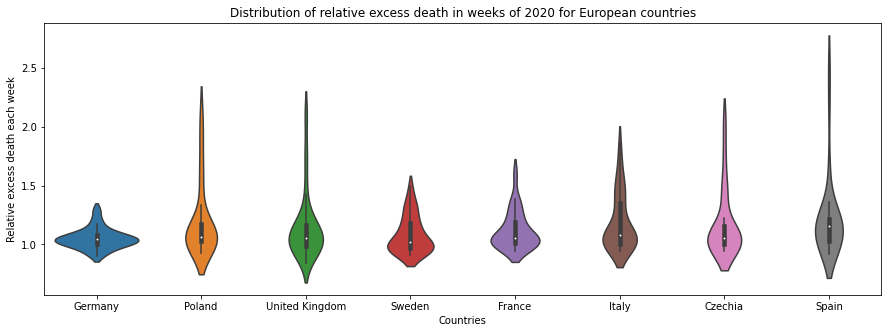

In [23]:
def plot_relative_excess_violin(df):
    df_2 = pd.DataFrame()
    for country in countries:
        df_2[country] = df[country]['Relative death']  
    df_2 = df_2.melt(var_name='Countries', value_name='Relative excess death each week')
    ax = sns.violinplot(x="Countries", y="Relative excess death each week", data=df_2, cut=1.25)
    
plt.figure(figsize=(15,5))
plt.title("Distribution of relative excess death in weeks of 2020 for European countries")
plot_relative_excess_violin(excess_df)

The violin plot gives a plot of the density of each country's excess deaths for each week. Accompanying the density plot is a boxplot, with the black box indicating the interquartile range and the black lines stretched from the bar showing the lower/upper adjacent values. These show the distribution of the relative increase in death for each week across each country, allowing easy comparison between the countries. 

This plot shows us graphically how each country experienced somewhat similar average relative death for each week, as was discussed (Median value is shown as a white dot in each density plot). Once again we can see that in many countries, Covid led to extremely large peaks of excess death. However, likely due to restriction measures, the distribution for each country remains mostly concentrated around only slightly above 1.

We once again see here that Spain was the hardest hit country in terms of the peak relative excess death, far exceeding other countries. However, we can see Italy has a particularly wider distribution of weeks of excess death than other countries, likely due to its increase in deaths seen during the second wave alongside its impact from the first wave.

We can see from this distribution again that Germany and Sweden seem to have the lowest rates of excess death, with Germany showcasing a particularly different distribution to the other countries, concentrated far more around 1. This would indicate that Covid-19 simply did not affect Germany as badly as other countries in 2020.

We can also see that despite Poland and Czechia having their peaks later in the year in the second wave, the distribution of excess death is just as bad as some of the worst hit countries of the first wave. This shows us how despite learning more about the virus and having more time to prepare hospitals, the Covid-19 situation in these countries hit by the second wave manifested itself to be just as bad as seen in countries in the first wave.

#### Covid-19 reported deaths vs. estimated excess deaths

Countries each provide statistics on their Covid-19 related fatalities. We have collected this to our dataframe, and will now compare these numbers for each week with the calculated excess deaths. This plot will give us an insight into the disparity between the estimated increase in death seen in countries, and how this compares with the reported Covid-19 death figures announced.

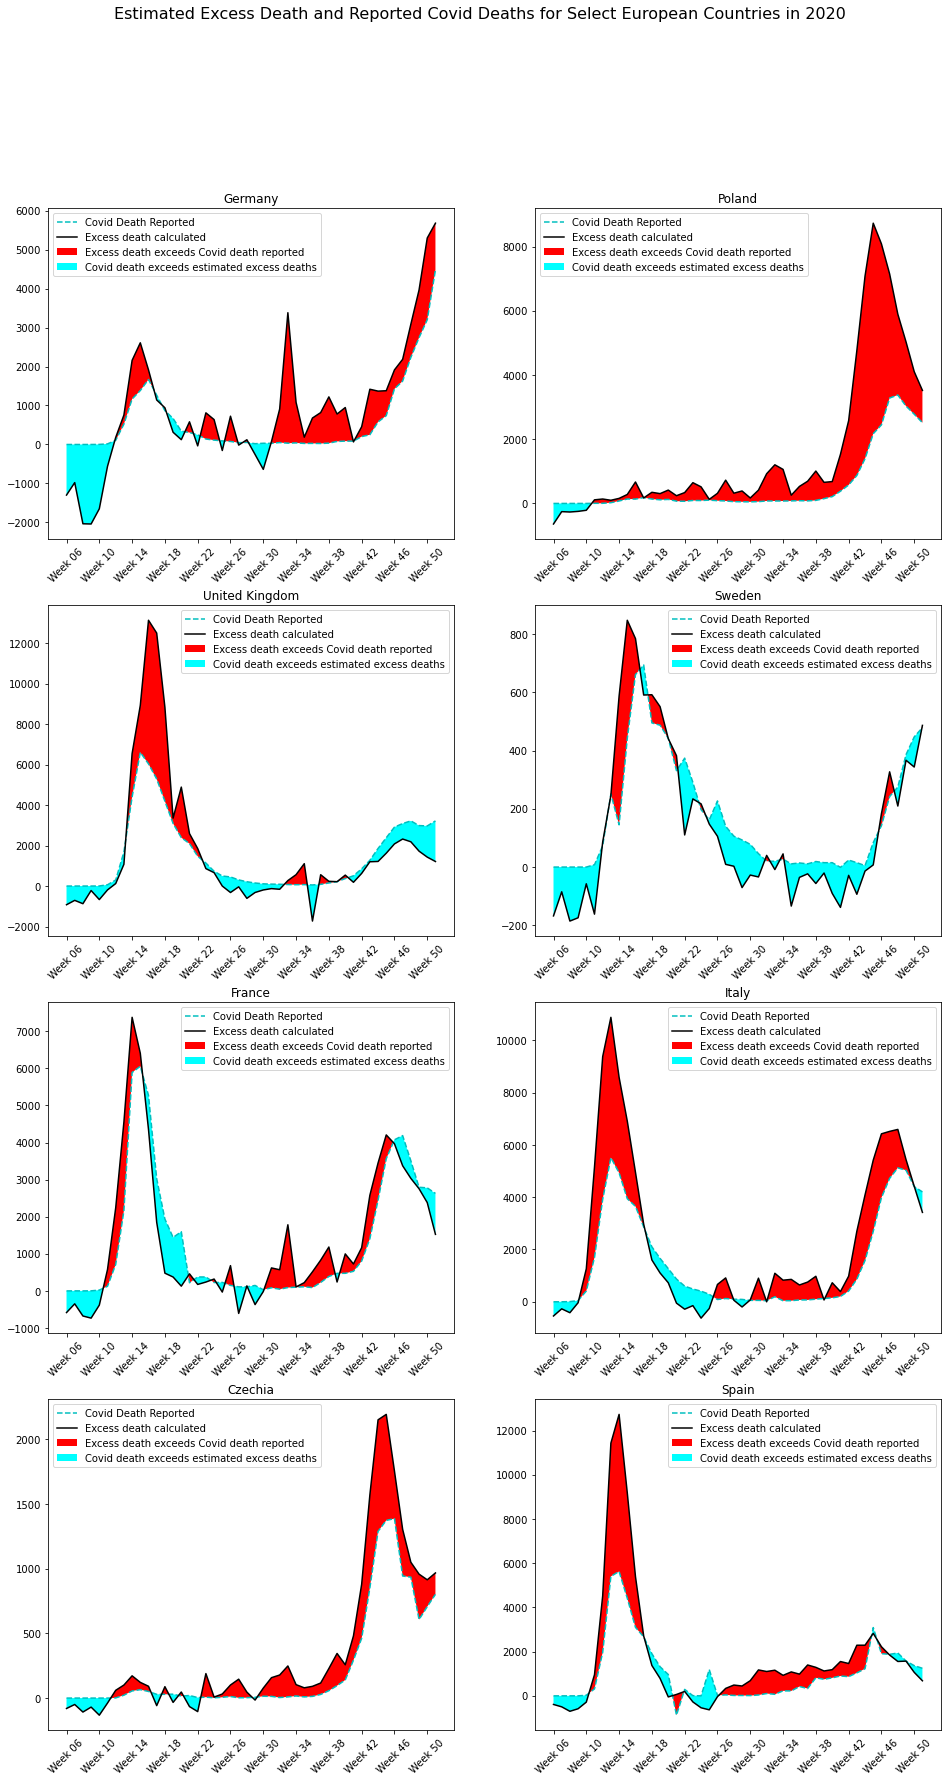

In [24]:
# Plots a country's Covid-19 related deaths vs the calculated Excess deaths
def plot_excess_vs_covid(ax, excess_df,country):
    df_ger = excess_df[country] # Get dataframe for just that country
    x = df_ger.index # Weeks
    y1 = df_ger["Covid death"]
    y2 = df_ger["Excess death"]
    # Get every 4th week as a label
    j=0
    labels=[]
    for index in df_ger.index:
        if (j%4==0):
            labels.append("Week "+index[-2:])
        j=j+1
    ax.plot(x, y1,'c--', x, y2, 'k')
    ax.set_xticks(range(0,len(excess_df),4))
    ax.set_xticklabels(labels, rotation=45)
    ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='red', interpolate=True)
    ax.fill_between(x, y1, y2, where=y2 <= y1, facecolor='cyan', interpolate=True)
    ax.set_title(country)
    ax.legend(["Covid Death Reported", "Excess death calculated", "Excess death exceeds Covid death reported", "Covid death exceeds estimated excess deaths"])

# 8 figures, one for each country
figures = [0,0,0,0,0,0,0,0]
fig, ((figures[0], figures[1]), (figures[2], figures[3]),
      (figures[4], figures[5]), (figures[6], figures[7])) = plt.subplots(4,2, figsize=(16,28))
fig.suptitle('Estimated Excess Death and Reported Covid Deaths for Select European Countries in 2020', fontsize=16)
i=0
# Call function for each country for each subplot position
for country in countries:
    plot_excess_vs_covid(figures[i], excess_df,country)
    i+=1

We can clearly see from this graph that as Covid deaths are higher, the number of excess deaths generally follows also. At a cursory glance, we can see there is an obvious correlation between the two, as we would expect. 

There are a few key points we can also take from these graphs:

1. At the peak of each countries' excess deaths, the number of people dying is routinely higher in the country than just reported from Covid. This could show just how straining the pandemic can be in ways which are not exclusively the disease itself. Hospitals may be becoming crowded at this time, and care cannot be given to those who need it.


2. The differences in reported covid deaths and excess deaths varies widely by country. We can visually see that in countries such as France, the excess death figure closely follows the calculated excess death, while in Spain the peak of excess death is remarkably higher than the peak of reported covid death. In Poland, the excess death figures are consistently far higher than what is reported as Covid-19 related deaths.


3. We can observe that some countries see a closer reporting of the Covid death figures to excess death figures in the second wave of the pandemic. At this time, countries such as Sweden, the UK and France are generally reporting more deaths from Covid than excess deaths seen relative to the previous four years. This could be due to a number of factors, including increased testing capability, or more liberal criteria for what is constituted as a death from Covid-19. Additionally, lockdown measures may be preventing deaths from other sources, lowering the total death figure and thus the excess figure. Also, there could be a lag of reporting deaths from the previous wave. A more thorough analysis of sources of mortality could be performed as future work.

Let's have a look at the absolute value for peak and mean Covid-19 death and Excess death in this time period for each country.

In [25]:
print("Peak excess death and covid-19 confirmed death for select European countries in 2020\n")
print("Country".ljust(16), "Peak Covid Death\t".ljust(12), "Peak Excess Death".ljust(12))
for country in countries:
    print(country.ljust(14), "  (%.3f)  " % (excess_df[country]["Covid death"].max()),
          "   \t(%.3f) " % ((excess_df[country]["Excess death"].max())))

Peak excess death and covid-19 confirmed death for select European countries in 2020

Country          Peak Covid Death	 Peak Excess Death
Germany          (4476.000)      	(5677.000) 
Poland           (3376.000)      	(8727.000) 
United Kingdom   (6603.000)      	(13130.000) 
Sweden           (694.000)      	(847.500) 
France           (6055.000)      	(7375.500) 
Italy            (5514.000)      	(10881.000) 
Czechia          (1388.000)      	(2194.000) 
Spain            (5625.000)      	(12730.750) 


In [26]:
print("Mean excess death and covid-19 confirmed death for select European countries in 2020\n")
print("Country".ljust(15), "Mean Covid Death ".ljust(10), "    Mean Excess Death".ljust(10))
for country in countries:
    print(country.ljust(15), "(%.3f)" % (excess_df[country]["Covid death"].mean()) 
          ,"\t".ljust(6),"(%.3f)" % ((excess_df[country]["Excess death"].mean())))

Mean excess death and covid-19 confirmed death for select European countries in 2020

Country         Mean Covid Death      Mean Excess Death
Germany         (589.348) 	      (874.603)
Poland          (553.783) 	      (1537.402)
United Kingdom  (1472.130) 	      (1685.179)
Sweden          (173.761) 	      (137.755)
France          (1326.500) 	      (1365.500)
Italy           (1504.652) 	      (2295.951)
Czechia         (226.326) 	      (359.880)
Spain           (1070.870) 	      (1697.647)


We can see here that for various countries, the peak Covid death rate is far lower than the peak excess death rate seen. For instance, in Poland, Covid death peaked at 3376 while the calculated excess death was 8727. The mean values typically follow a similar trend as we can see.

#### Total covid deaths as a percentage of estimated excess deaths

Let us then look at which countries' calculated excess deaths are closest to the reported Covid-19 deaths. For this bar chart, we find the sum of all Covid deaths in Weeks 6 to 51, and divide by the total Excess deaths seen in the same time frame.

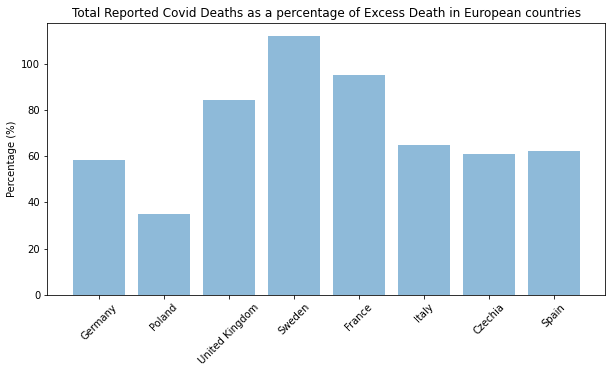

In [28]:
y_pos = [0,1,2,3,4,5,6,7]
performance = [] # y-values
for country in countries:
    df_copy = excess_df[country][excess_df[country]["Covid death"]>0]
    performance.append((df_copy["Covid death"].sum() / df_copy["Excess death"].sum() )*(100))
plt.figure(figsize=(10,5))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, countries, rotation=45)
plt.ylabel('Percentage (%)')
plt.title('Total Reported Covid Deaths as a percentage of Excess Death in European countries')
plt.show()

This statistical comparison is extremely interesting as it provides a perspective on how the Covid death figures relate to the actual mortality above the norm seen in the country during the same period.

Typical public perception of Sweden's approach to the pandemic has been that there has been needless death in the country due to the relatively relaxed measures, typified by their high covid death rate relative to neighbours. However, we can see here that in Sweden, covid deaths have been counted as higher than the excess death seen in the country, which could give a perception of the country's health service being harder hit by the pandemic than the excess death figures show.

Sweden having more excess deaths than Covid-19 deaths could be indicative that Covid-19 is not causing additional death due to strain on hospital services in Sweden.

Poland, as we see here, can only account for 35% of its excess death with Covid-19 deaths it has reported. Countries like Poland, Spain, Germany and Italy could be showing Covid-19 death figures which do not show the full extent of the strain it is causing on their society. This could be due to a number of factors.

1. These countries could have weaker healthcare systems and thus an excess of Covid patients is causing a surge in mortality due to other factors. These countries may not have the resources to care for those who are sick with other diseases/ailments when overwhelmed with Covid-19.

2. These countries could have weaker, less targeted testing approaches which may not be picking up cases which result in death. They also could have stricter requirements for what is constituted as a death from Covid-19.

Fundamentally it can be argued that these statistics show that raw death figures can be a misleading measure with which to compare different countries' performance in the pandemic. Many countries are facing levels of mortality which are not entirely accounted for by the reported death figures.

## <font color=red> 6:</font> Potential Future Work

For future work, it would be very interesting to see for what precise reasons the Covid-19 death figures vary from the excess death figures for each country. Statistics on hospital capacity and capabilities, Covid-19 testing capacity, and demographic information such as age profile of the population could be indicative of the discrepancy for each country. Additionally, information of the profile of deaths would be very interesting to look at. In countries like Poland where the Covid-19 death rate is far lower than the excess death, it would be interesting to see what are the most popular reasons for death listed on certificates. This could be another key feature in understanding this discrepancy.

It would also be very interesting to view projections of to what extent excess mortality could have become had lockdowns in badly hit countries like Spain not been put in place. While my analysis shows just how extreme mortality became during Spain's worst weeks, this lockdown could be justified further if predictions could be made on how it would have continued without a lockdown. Features such as increasing case numbers, hospitalisations and capacity could be considered to predict Covid's effect on mortality if lockdown was not put in place.

## <font color=red> 7:</font> Conclusions

The intention of this report was to review just how much more people were dying as a result of the Covid-19 pandemic, and how these numbers related to the announced figures of deaths from the disease. Through the use of the Covid-19 and Eurostat API for gathering these important statistics, this analysis has been achieved, with the following as some of the conclusions formed from this analysis:
    
1. The Covid-19 pandemic has led to a significant increase in excess mortality in Europe, most prevalent at peaks which have been supressed by counteracting measures. The peak excess death seen across countries varies in extent and occurence. Spain has been shown as the hardest hit, where an increase of 2.58 times the typical weekly death toll seen in week 14 of 2020. Poland was hardest hit in the second wave with an increase of 2.16 times the typical weekly death toll seen in Week 45. Most countries maintained similar low excess death on average throughout the year, however. This is presumably due to containment measures, with Spain recording the largest mean weekly death increase at 22%.



2. Covid-19 death tolls from countries often do not give the full picture for how much the pandemic is affecting mortality in the country. In Poland, Covid-19 death figures in the period between Week 6 and Week 51 are only 35% of the excess mortality figure for the same period. In Sweden, this figure is 111%. This suggests there is variety in European countries of testing capability, criteria for being counted as a Covid-19 death, and potentially hospital services being able to cope for other ailments when Covid infection is rampant. My analysis shows that the death figure could be potentially misleading as a performance indicator for a country in the pandemic.